# Time series prediction models

Some content from:
https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

# Part 1

Let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day:

In [48]:
import matplotlib.pyplot as plt  
%matplotlib inline
from scipy.stats import norm

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import random
import pandas as pd
import numpy as np  
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time']).dropna()
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time']).dropna()

In [49]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

**Note:** Since we have two different datasets (although related with the same problem), "ads" and "currency", in this notebook we will do something different than before: we apply each operation in the "ads" dataset, and you'll do the same on the "currency". You need to pay attention, because it's not always exactly the same thing, especially when the model starts to get complicated!

Let's start by plotting the time series

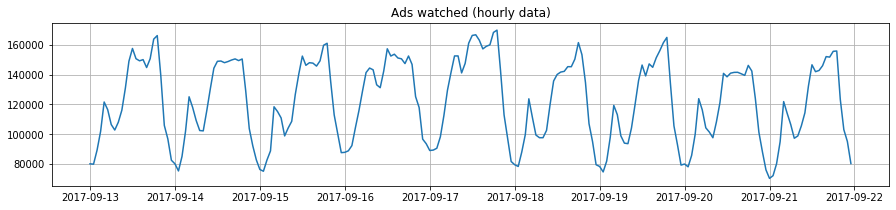

In [50]:
plt.figure(figsize=(15, 3))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

...and the histogram of the same variable

In [51]:
ads_mean=ads['Ads'].mean()
ads_std=ads['Ads'].std()
x_axis=np.arange(ads_mean-3*ads_std,ads_mean+3*ads_std, 100)

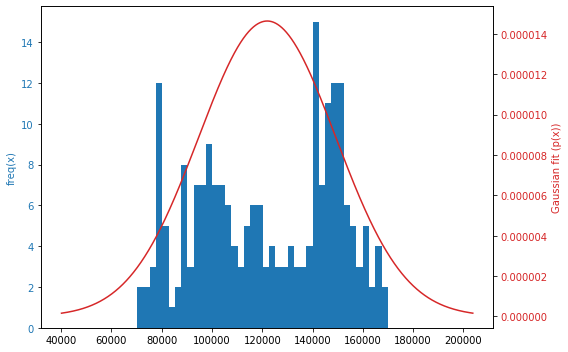

In [52]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_ylabel('freq(x)', color=color)  # we already handled the x-label with ax1
ax1.hist(ads['Ads'], bins=40, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Gaussian fit (p(x))', color=color)
ax2.plot(x_axis, [norm.pdf(x, ads_mean, ads_std) for x in x_axis], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.show()


We superimpose the normal fit, just to show that it's certainly not a Gaussian fit, maybe it is some mixture of two or three Gaussians?

Your turn to do the same with the other dataset

# Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

We also add the mean absolute squared error (MAPE) which is actually a popular one in Time series analysis

In [56]:
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In order to speed things up a bit, we made this function below for you. It allows to plot together the original time series and its prediction model.

In [57]:
def plotprediction(series, pred_series, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    

    # Plot confidence intervals for smoothed values

    plt.legend(loc="upper left")
    plt.grid(True)

In [58]:
def timeseries_train_test_split_indexes(ts, test_size):
    """
        Gets the two vectors with indexes for the train test split (first vector is train observations, 
        second vector is test observations).
    """
    
    # get the index after which test set starts
    split_time = int(len(ts)*(1-test_size))
    
    test_index=ts.iloc[split_time:].index[0]
    
    return ts.index<test_index, ts.index>=test_index


In [59]:
def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

# Copy, move, smoothe

Let's start with the most naive hypothesis: "tomorrow will be the same as today". Can you do that?

Let's create a new column in the ads dataframe called "copy_pred" to host your predictions.

In [60]:
ads_train_ix, ads_test_ix=timeseries_train_test_split_indexes(ads, 0.3)

In [61]:
ads['copy_pred']=[0]+ads['Ads'].to_list()[:-1]

Visualization will look quite intuitively (notice that we're visualizing almost always only the test set predictions).

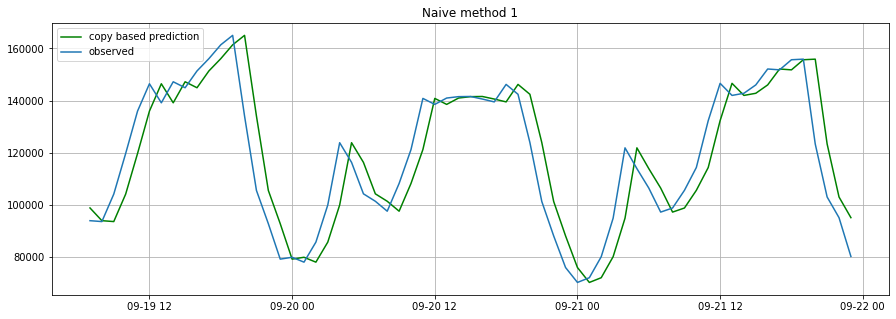

In [62]:
plotprediction(ads[ads_test_ix]['Ads'], ads[ads_test_ix]['copy_pred'], labels=['observed', 'copy based prediction'], title="Naive method 1")

Let's evaluate it

In [63]:
print_stats(ads[ads_test_ix]['Ads'], ads[ads_test_ix]['copy_pred'], "copy method")

copy method: 
	r^2=0.781031
	MAE=9378.384615
	MAPE=8.396050


Do this yourself on the other dataset

Hard to say much yet because it's only our first model, but you should notice that the first time series is much easier to fit than the second one. Let's move on to the next method!

We assume that the future value of our variable depends on the plain average of its k previous values. 
$$
y_t=\frac{1}{k}\sum_{n=1}^k y_{t−n}
$$
Can you implement a function that does that?

In [115]:
import numpy as np  

def plain_moving_average(series, n):
    #write your code here



In [69]:
ads['ma_pred']= plain_moving_average(ads['Ads'], 3)



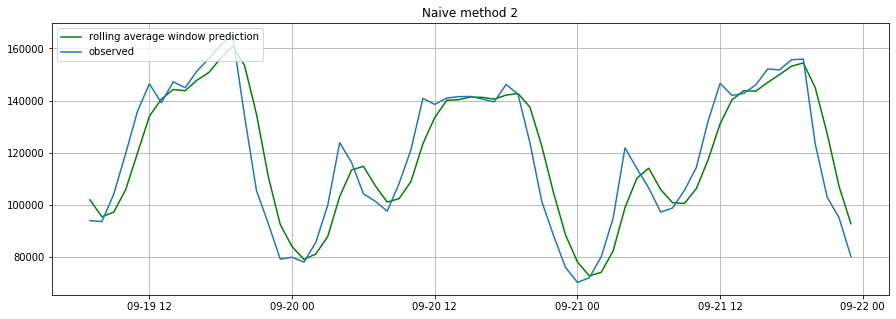

In [70]:
plotprediction(ads[ads_test_ix]['Ads'], ads[ads_test_ix]['ma_pred'], labels=['observed', 'rolling average window prediction'], title="Naive method 2")

In [71]:
print_stats(ads[ads_test_ix]['Ads'], ads[ads_test_ix]['ma_pred'], "MA smoothing")


MA smoothing: 
	r^2=0.825630
	MAE=8338.769231
	MAPE=7.622204


Don't forget to compare with the previous models you get. In this case, you'll see that our model already has improved quite a bit. 

Do you want to see if the same happens with the currency dataset?

Looks a little better, but unfortunately we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But plain moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

Let's smooth the entire currency dataset by the previous 4 hours and 24 hours.

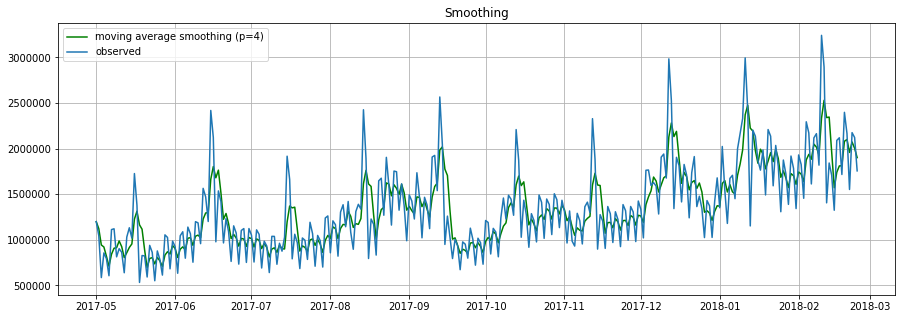

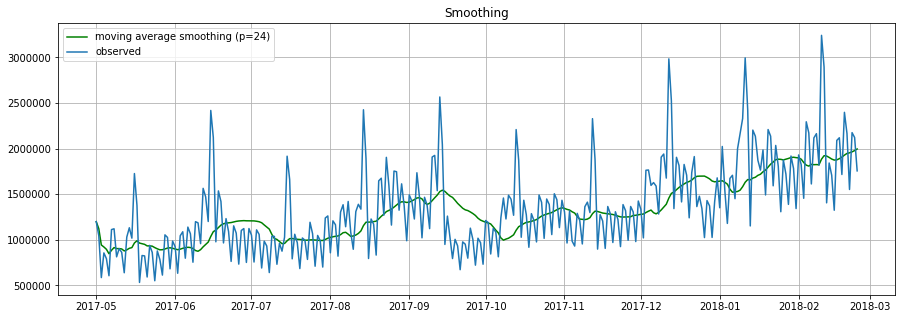

In [75]:
plotprediction(currency['GEMS_GEMS_SPENT'].as_matrix(), plain_moving_average(currency['GEMS_GEMS_SPENT'], 4), x_axis=currency.index, labels=['observed', 'moving average smoothing (p=4)'], title="Smoothing")
plotprediction(currency['GEMS_GEMS_SPENT'].as_matrix(), plain_moving_average(currency['GEMS_GEMS_SPENT'], 24), x_axis=currency.index,labels=['observed', 'moving average smoothing (p=24)'], title="Smoothing")

You should notice the downside of our simple approach. With p=4, we are clearly missing most peaks (should we use much smaller p? should we check the ACF?). Let's try other approaches

-------------------

# Part 2 

# Autoregressive model

Shifting the series n steps back, we get a feature column where the current value of time series is aligned with its value at time t−n. You have done this before a couple of times. 

If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [76]:

# Creating a copy of the initial datagrame to make various transformations 
ads_data = pd.DataFrame(ads.Ads.copy())

There's a couple of very useful functions to determine Autocorrelation and Partial Autocorrelation

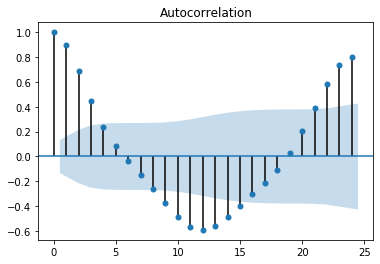

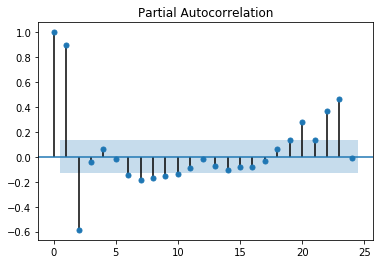

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ads_data['Ads'])
plot_pacf(ads_data['Ads']);

A common rule of thumb is to consider PACF for the AR degree - essentially find the N first lags that are above the confidence interval. Having this in mind, we will now assume AR(3) for the "ads" dataset.

An important note is that this rule is **just** an indication for the starting point. It is quite common that you need to try different values. 

In [78]:
LAGS=3 # Adding the lag of the target variable up to 3 steps back. FEEL FREE to try other values
for i in range(1,LAGS+1):
    print("adding lag")
    ads_data["lag_{}".format(i)] = ads_data.Ads.shift(i)


# take a look at the new dataframe 
ads_data.tail(7)

adding lag
adding lag
adding lag


,Ads,lag_1,lag_2,lag_3
Time,,,,
2017-09-21 17:00:00,151790,152120.0,146020.0,142815.0
2017-09-21 18:00:00,155665,151790.0,152120.0,146020.0
2017-09-21 19:00:00,155890,155665.0,151790.0,152120.0
2017-09-21 20:00:00,123395,155890.0,155665.0,151790.0
2017-09-21 21:00:00,103080,123395.0,155890.0,155665.0
2017-09-21 22:00:00,95155,103080.0,123395.0,155890.0
2017-09-21 23:00:00,80285,95155.0,103080.0,123395.0


Before using the classical statsmodels package for this, let's use our good old friend SKLEARN.

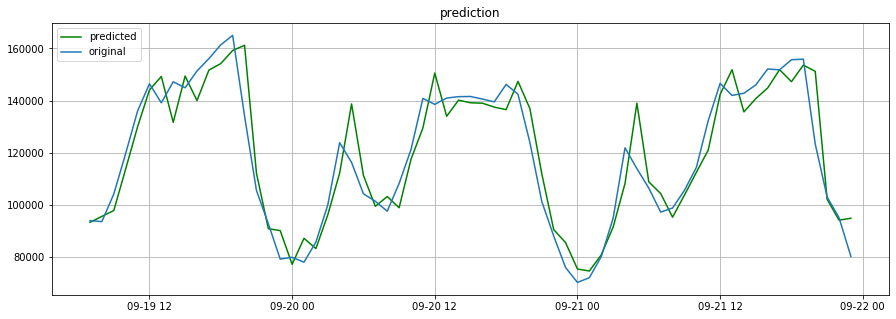

In [79]:
from sklearn.linear_model import LinearRegression


y = ads_data.Ads
X = ads_data.drop(['Ads'], axis=1)

X_train, X_test, y_train, y_test = X[ads_train_ix], X[ads_test_ix], y[ads_train_ix], y[ads_test_ix]

X_train=X_train[LAGS:]  #because the first LAGS observations will have NaNs
y_train=y_train[LAGS:]

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred=lr.predict(X_test)

plotprediction(y_test, y_pred)


In [80]:
print_stats(y_test, y_pred, "AR (3)")

AR (3): 
	r^2=0.871260
	MAE=7135.221469
	MAPE=6.115622


It keeps improving, right?  :-)

Let's do it now the "right way", which means using the ARMA object of statsmodels package 

In [81]:
# MA example
from statsmodels.tsa.arima_model import ARMA, ARIMA

Besides using a different model, we'll train it in a very different way: 
- Before making each prediction, we re-estimate the model with ALL previous data
- We will have N models estimated, although we only keep the last one, just for inspection


In [82]:
preds=[]
for l in ads_data[ads_test_ix]['Ads'].index:
    data=ads_data['Ads'][ads_data.index<l]
    model=ARMA(data, order=(3, 0))
    AR=model.fit()
    
    preds.append(AR.forecast()[0])
    
y_pred=np.array(preds).T[0]

Let's compare the coefficients obtained of the last model trained. It is "just" a linear regression of the lagged values, so they shouldn't be too different than the sklearn version, despite the dataset differences mentioned. 

In [83]:
AR.params

const        122167.953483
ar.L1.Ads         1.487642
ar.L2.Ads        -0.661860
ar.L3.Ads         0.021652
dtype: float64

In [84]:
lr.coef_

array([ 1.50960382, -0.69750324,  0.04547867])

In [85]:
lr.intercept_

17573.45904002992

You may ask "Hmm... but aren't we repeating the same thing too many times? Isn't this a waste of time?". It depends on the case... if you do have time, it may be worth it. Sometimes, you even have a data moving window (i.e. you remove the oldest datapoints each time you re-estimate).

Let's visualize

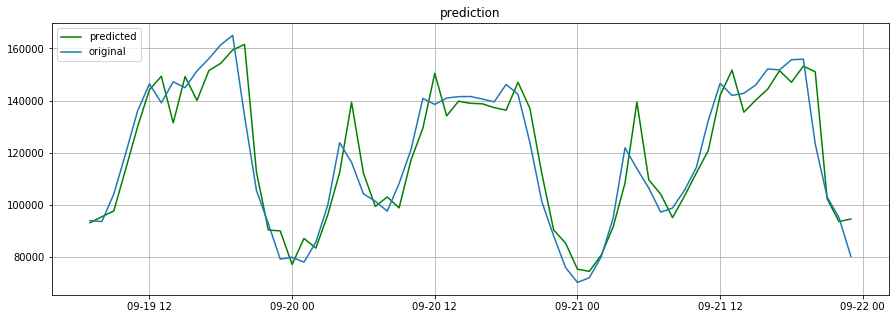

In [86]:
plotprediction(ads_data[ads_test_ix]['Ads'], y_pred)


In [87]:
print_stats(y_test, y_pred, "AR(3)")

AR(3): 
	r^2=0.869169
	MAE=7236.270009
	MAPE=6.193161


So, AR is generally an improvement. Do you want to check if the same verifies in the currency dataset?

# Adding moving average (MA) model component

Now let's move on to the MA component of our model. Again, the ACF result can help you guide yourself. **However**, the model now will be more sensitive to estimate. You should always try with the lowest values, because it's possible that the model is not possible to estimate (invert) anyway... 

What people do is select the degree by the number of first ACF correlations that are **clearly** above the confidence interval. 

Let's run the ACF/PACF code again 

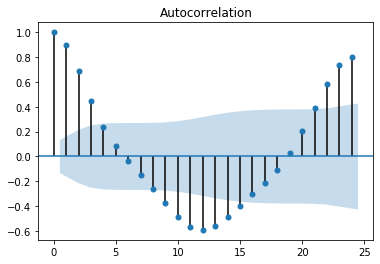

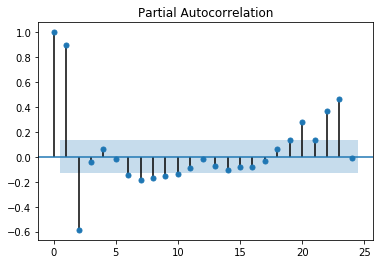

In [93]:
plot_acf(ads_data['Ads'])
plot_pacf(ads_data['Ads']);

Should we try MA=1 to 3? You need to keep the AR degree you chose from before, otherwise it'll be even harder to estimate. So, why not trying (3, 2), where AR=3 and MA=2?

In [94]:
preds=[]
for l in ads[ads_test_ix]['Ads'].index:
    data=ads['Ads'][ads.index<l]
    model=ARMA(data, order=(3, 2))   #Here is where you tell ARMA what the order is
    arma=model.fit()
    
    preds.append(arma.forecast()[0])
    
y_pred=np.array(preds).T[0]

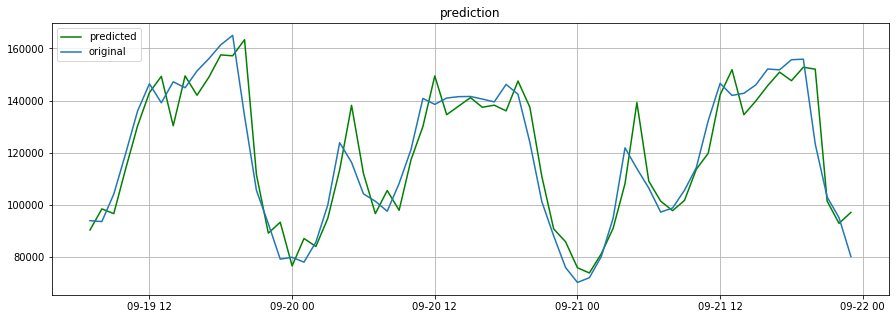

In [95]:
plotprediction(y_test, y_pred)



In [96]:
print_stats(y_test, y_pred, "ARMA (3,2)")

ARMA (3,2): 
	r^2=0.861275
	MAE=7534.743482
	MAPE=6.513637


Hmmm... it didn't necessarily improve much! :-( Feel free to try other AR, MA degree combinations. 

Can you replicate the analysis with the currency dataset?

-------

# ARIMA

We finally arrived to the last model: the full ARIMA model, which has all components, of Auto Regressive (AR), Integration (I) and Moving Average (MA). 

A crucial question now relates to the I component. Is the data already stationary? Do we need to 
work on it?

The first thing to do is run the Augmented Dickey-Fuller (ADF) test 

In [100]:
from statsmodels.tsa.stattools import adfuller

In [101]:
result = adfuller(ads['Ads'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.089634
p-value: 0.000000
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


From ADF test, it's clear that the data is stationary enough not to need the I part. I.e., we'll keep our model as (3, 0, 2). 

In [102]:
preds=[]
for l in ads[ads_test_ix]['Ads'].index:
    data=ads['Ads'][ads.index<l]
    model=ARIMA(data, order=(3, 0, 2)) #Notice that now we're using the ARIMA object
    arima=model.fit()
    
    preds.append(arima.forecast()[0])
    
y_pred=np.array(preds).T[0]

In [103]:
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:                    Ads   No. Observations:                  215
Model:                     ARMA(3, 2)   Log Likelihood               -2262.948
Method:                       css-mle   S.D. of innovations           8954.908
Date:                Tue, 22 Oct 2019   AIC                           4539.896
Time:                        13:40:33   BIC                           4563.490
Sample:                    09-13-2017   HQIC                          4549.429
                         - 09-21-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.222e+05   4190.905     29.151      0.000    1.14e+05     1.3e+05
ar.L1.Ads      0.7074      0.247      2.866      0.005       0.224       1.191
ar.L2.Ads      0.3833      0.361      1.062      0.2

Always pay attention to the p-values in this table. Whenever they have values very different than 0 (e.g >0.05), then you can consider removing that variable... You can try changing your parameters above accordigly. 

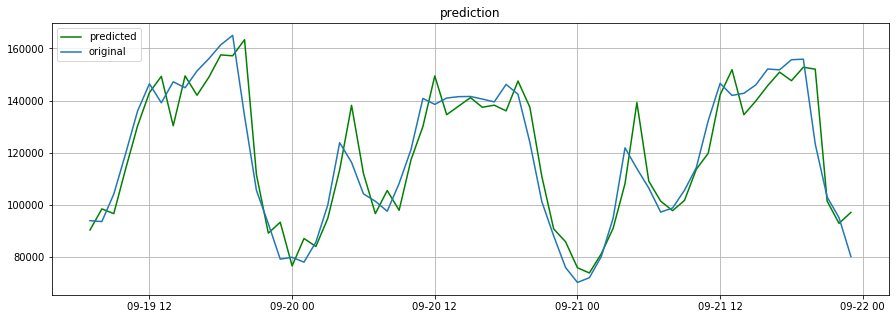

In [104]:
y_test=ads[ads_test_ix]['Ads']
plotprediction(y_test, y_pred)


In [105]:
print_stats(y_test, y_pred)

You forgot the title!: 
	r^2=0.861275
	MAE=7534.743482
	MAPE=6.513637


Now, let's try with the currency data? 

Some tips:
- This time, the analysis may be quite different. So don't just replicate from above. Look at the results step by step
- It's possible that the best is to ignore findings from above (for example reducing the AR or MA degrees to get it to work)
- If you want to try multiple combinations, you should split the training dataset into train+development set
- You can make a brute-force approach (e.g. 3 for loops, one per p, q, d), and run it overnight... If you do this, you need to use a "try  ... except" block because your code will crash a few times.  

-------------

# Part 3

We're going now for the generic modeling tools (i.e. SKLEARN). The approach is to prepare the data so as to reflect the time series nature. You can use what you learned from above (e.g. AR degree). 

In [110]:

# Creating a copy of the initial datagrame to make various transformations 
ads_data = pd.DataFrame(ads.Ads.copy())

Let's try a few... feel free to add whatever other models you like

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

We'll test them all in sequence and just see the results

In [112]:

models=[GradientBoostingRegressor(), LinearRegression(), MLPRegressor()]


for md in models:
    print("\n\nTesting ", str(type(GradientBoostingRegressor())))
    preds=[]
    for l in ads_data[ads_test_ix]['Ads'].index:  #Just like with the ARIMA models, we're retraining the model each time 
                                          #we make a new prediction 
        data_extract=ads_data[ads_data.index<=l]
        LAGS=3        
        # Adding the lag of the target variable up to 6 steps back
        for i in range(1,LAGS+1):
            data_extract["lag_{}".format(i)] = data_extract.Ads.shift(i)
        data_extract=data_extract.dropna()
        y = data_extract['Ads'][:-1]
        X = data_extract.drop(['Ads'], axis=1)[:-1]

        md.fit(X, y)
        pred=md.predict(np.array(data_extract.drop(['Ads'], axis=1).iloc[-1], ndmin=2))
        preds.append(pred)

    y_pred=np.array(preds).T[0]
    print_stats(y_test, y_pred, str(type(GradientBoostingRegressor())))



Testing  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>: 
	r^2=0.893425
	MAE=6181.581994
	MAPE=5.385911


Testing  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>: 
	r^2=0.869165
	MAE=7207.097119
	MAPE=6.176428


Testing  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>: 
	r^2=0.353201
	MAE=16022.967913
	MAPE=15.131812


Do the results for the other dataset show the same pattern (of Gradient Boosting being the best, beating ARIMA also)?